# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Rander metrics

In this notebook, we solve Rander eikonal equations on the CPU and the GPU, and check that they produce consistent results.

*Note on the numerical schemes*: The numerical schemes solved by the CPU and GPU in the Rander case are entirely different. The CPU version uses a causal semi-Lagrangian scheme, two dimensional only, whereas the GPU version uses a non-causal (yet monotone) Eulerian scheme, in two and three dimensions.

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Constant metric](#1.1-Constant-metric)
    * [1.2 Zermelo's problem](#1.2-Zermelo's-problem)
  * [2. Three dimensions](#2.-Three-dimensions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

norm_infinity = ad.Optimization.norm_infinity
from agd.HFMUtils import RunGPU,RunSmart

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU,RunSmart,Metrics
    HFMUtils,ad,cugen,RunGPU,Metrics = rreload([HFMUtils,ad,cugen,RunGPU,Metrics],"../..")    
    RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
RunSmart = cugen.cupy_get_args(RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

### 0.1 Utilities

In [6]:
#from Notebooks_GPU.ExportedCode.Isotropic_Repro import RunCompare
def RunCompare(gpuIn,check=True):
    gpuOut = RunGPU(gpuIn)
    if gpuIn.get('verbosity',1): print("---")
    cpuIn = gpuIn.copy(); cpuIn.pop('traits',None)
    cpuOut = RunSmart(cpuIn)
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
    cpuTime = cpuOut['FMCPUTime']; stencil_cpuTime=cpuOut['StencilCPUTime']; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU solver : {gpuTime}, CPU solver {cpuTime}, CPU stencil Stencil {stencil_cpuTime}." 
          f"Device acceleration : {(cpuTime+stencil_cpuTime)/gpuTime}")
    assert not check or cp.allclose(gpuOut['values'],cpuOut['values'],atol=1e-5,rtol=1e-4)
    return gpuOut,cpuOut

In [7]:
factor_variants = [
    {}, # Default
    {"seedRadius":2}, # Spread seed information
    {"factorizationRadius":10,'factorizationPointChoice':'Key'} # Source factorization
]
multip_variants = [
    {'multiprecision':False}, # Default
    {'multiprecision':True}, # Reduces roundoff errors
]
order_variants = [
    {'order':1}, # Default
    {'order':2}, # More accurate on smooth instances
]

## 1. Two dimensions

### 1.1 Constant metric

In [8]:
n=100
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
    'factoringRadius':20,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['metric'] = Metrics.Rander(cp.eye(2),cp.array([0.5,0.]) )

Casting output of function array from float64 to float32
Casting output of function eye from float64 to float32
Casting output of function array from float64 to float32


In [9]:
gpuOut,cpuOut = RunCompare(hfmIn,check=False)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.031476736068725586 seconds, in 14 iterations.
Post-Processing
---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 0.024 s.
Max |gpuValues-cpuValues| :  0.002103818574902272
Solver time (s). GPU solver : 0.031476736068725586, CPU solver 0.024, CPU stencil Stencil 0.024.Device acceleration : 1.5249357460442499


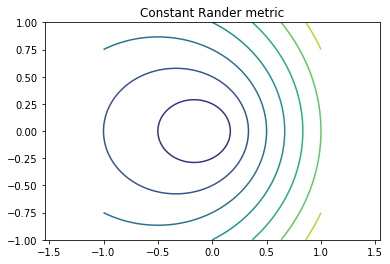

In [36]:
plt.title("Constant Rander metric"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

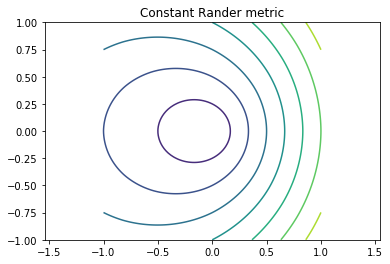

In [143]:
plt.title("Constant Rander metric"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),cpuOut['values']);

### 1.2 Zermelo's problem

We obtain $\times 40$ speedup at resolution $2000\times 2000$ already. The lack of causality does not seem to be a significant issue for the GPU solver. The cost of the FM-ASR adaptive stencils cannot be neglected. 

In [113]:
n=4000
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
})
hfmIn.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)

Casting output of function array from float64 to float32


In [114]:
def Drift(x):
    mult = 0.9*np.sin(x[0])*np.sin(x[1]) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

In [115]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmIn.Grid()))

Casting output of function eye from float64 to float32


In [116]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 1.4614970684051514 seconds, in 562 iterations.
Post-Processing


In [117]:
gpuOut,cpuOut = RunCompare(hfmIn,check=False);

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 1.4574995040893555 seconds, in 562 iterations.
Post-Processing
---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 69.963 s.
***** Warning ! *****
Unused fields from user: raiseOnNonConvergence 
********************
Max |gpuValues-cpuValues| :  0.013984917158148313
Solver time (s). GPU : 1.4574995040893555, CPU : 69.963. Device acceleration : 48.002074651622486


In [123]:
(cpuOut['StencilCPUTime']+cpuOut['FMCPUTime'])/gpuOut['solverGPUTime']

73.40311245378031

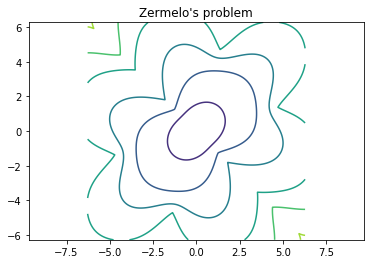

In [84]:
plt.title("Zermelo's problem"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

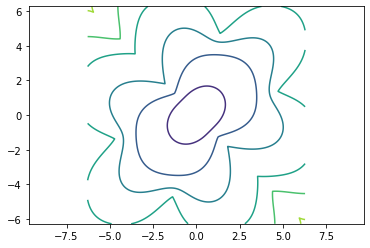

In [85]:
plt.axis('equal')
plt.contour(*hfmIn.Grid(),cpuOut['values']);

## 2. Three dimensions

As mentioned in the introduction, the CPU variant does not handle three dimensional problems. We generalize here Zermelo's problem, for the sake of testing array broadcasting.

In [127]:
n=200
hfmIn = HFMUtils.dictIn({
    'model':'Rander3',
    'seeds':cp.array([[0.,0.,0.]]),
    'exportValues':1,
    'raiseOnNonConvergence':False,
})
side = [-2.*np.pi,2.*np.pi]
hfmIn.SetRect([side,side,side],dimx=n+1)

Casting output of function array from float64 to float32


In [128]:
def Drift(x):
    mult = 0.9*np.prod(np.sin(x)) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

In [129]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(3),Drift(hfmIn.Grid()))

Casting output of function eye from float64 to float32


In [130]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.1804969310760498 seconds, in 77 iterations.
Post-Processing
